In [1]:
import loader_celebA as loader
import os
from glob import glob
import numpy as np
from matplotlib import pyplot
import tensorflow as tf
%matplotlib inline

/Users/am/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Found Celeb-A - skip


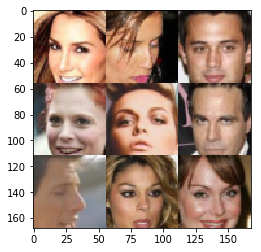

In [2]:
# Let's download the dataset from http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html under the link "Align&Cropped Images
# alternatively You can use  https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADIKlz8PR9zr6Y20qbkunrba/Img/img_align_celeba.zip?dl=1&pv=1
#  This function unzips the data and kreep all the images in celebA folder
loader.download_celeb_a()
  

# Let us explore the images
data_dir = os.getcwd()
test_images = loader.get_batch(glob(os.path.join(data_dir, 'celebA/*.jpg'))[:10], 56, 56)
pyplot.imshow(loader.plot_images(test_images))

In [3]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # using 4 layer network as in DCGAN Paper
        
        # First convolution layer
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        # Second convolution layer
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Third convolution layer
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
       
        # Flatten layer
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits

In [4]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected layer
        x_1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        deconv_2 = tf.reshape(x_1, (-1, 2, 2, 512))
        batch_norm2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Deconv 1
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 256, 5, 2, padding='VALID')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        
        # Deconv 2
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 128, 5, 2, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, 2, padding='SAME')
        
        out = tf.tanh(logits)
        
        return out


In [5]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    """
    
    label_smoothing = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
                                                  
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake) * label_smoothing))
    
    
    return d_loss, g_loss

In [6]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [7]:
def generator_output(sess, n_images, input_z, out_channel_dim):
    """
    Show example output for the generator
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    pyplot.imshow(loader.plot_images(samples))
    pyplot.show()

In [8]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_files):
    """
    Train the GAN
    """
    w, h, num_ch = data_shape[1], data_shape[2], data_shape[3]
    X = tf.placeholder(tf.float32, shape=(None, w, h, num_ch), name='input_real') 
    Z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    #model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    D_loss, G_loss = model_loss(X, Z, data_shape[3])
    D_solve, G_solve = model_opt(D_loss, G_loss, learning_rate, beta1)
    
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        train_loss_d = []
        train_loss_g = []
        for epoch_i in range(epoch_count):
            num_batch = 0
            lossD, lossG = 0,0
            for batch_images in get_batches(batch_size, data_shape, data_files):
                
                # values range from -0.5 to 0.5 so we scale to range -1, 1
                batch_images = batch_images * 2
                num_batch += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _,d_loss = sess.run([D_solve,D_loss], feed_dict={X: batch_images, Z: batch_z})
                _,g_loss = sess.run([G_solve,G_loss], feed_dict={X: batch_images, Z: batch_z})
                
                lossD += (d_loss/batch_size)
                lossG += (g_loss/batch_size)
                if num_batch % 500 == 0:
                    # After every 500 batches
                    print("Epoch {}/{} For Batch {}  Discriminator Loss: {:.4f} Generator Loss: {:.4f}".
                          format(epoch_i+1, epochs, num_batch, lossD/num_batch, lossG/num_batch))
                          
                    
                    generator_output(sess, 9, Z, data_shape[3])
            train_loss_d.append(lossD/num_batch)
            train_loss_g.append(lossG/num_batch)
    
    return train_loss_d, train_loss_g

Epoch 1/2 For Batch 500  Discriminator Loss: 0.0733 Generator Loss: 0.0750


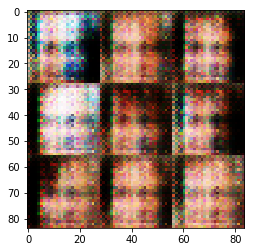

KeyboardInterrupt: 

In [9]:
# Data Parameters
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
data_files = glob(os.path.join(data_dir, 'celebA/*.jpg'))

#Hyper parameters
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 2
shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, 3
with tf.Graph().as_default():
    Loss_D, Loss_G = train(epochs, batch_size, z_dim, learning_rate, beta1, loader.get_batches, shape, data_files)

In [ ]:
pyplot.plot(Loss_D, label = 'Discriminator Loss')
pyplot.plot(Loss_G, label = 'Generator Loss')
pyplot.legend()
pyplot.xlabel('epochs')
pyplot.ylabel('Loss')